# Laboratorio 5 - Minería de Textos y Análisis de Sentimientos

### Sebastian Juarez - 21471
### Juan Pablo Cordón - 21458

Link al repositorio de Github: https://github.com/SebasJuarez/DS-Collection/tree/Lab5

## Avances

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Data/train.csv")

print(df.shape)
df.head()


(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


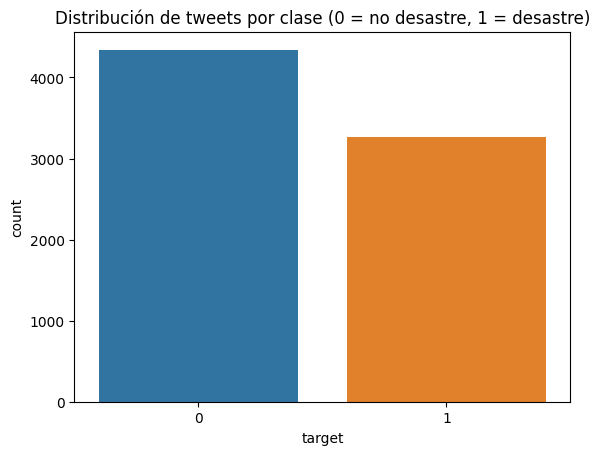

0    57.034021
1    42.965979
Name: target, dtype: float64

In [14]:
df.info()

df.isnull().sum()

sns.countplot(x="target", data=df)
plt.title("Distribución de tweets por clase (0 = no desastre, 1 = desastre)")
plt.show()

df["target"].value_counts(normalize=True) * 100


In [26]:
# Ver ejemplos de números en los tuits para ver como manejarlos
with_numbers = df[df["text"].str.contains("\d")]
# Mostrar ejemplos
for i in range(30):
    print(with_numbers.iloc[i]["text"])

13,000 people receive #wildfires evacuation orders in California 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
Damage to school bus on 80 in multi car crash #BREAKING 
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX


In [34]:
import re
import string

def clean_text(text):
    text = text.lower() # minusculas
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) 
    
    # Colocar en columna aparte hashtags
    hashtags = re.findall(r'\#\w+', text)
    text = re.sub(r'\@\w+|\#','', text)

    # Verificar emoticonos:
    emoticons = [":)","XD",":(",";)",":D", "B)", "8)", ":'(", ":P", ":p", ">:("]
    found_emoticons = [e for e in emoticons if e in text]
    # Quitar numeros a excepcion de "911"
    text = re.sub(r'\b\d+\b(?!\s*911)', '', text)

    # Cambiar "911" por "nine eleven"
    text = text.replace("911", "nine eleven")

    text = text.translate(str.maketrans('', '', string.punctuation)) # quitar puntuacion
    text = text.strip() 
    return text, hashtags, found_emoticons

df["clean_text"], df["hashtags"], df["emoticons"] = zip(*df["text"].apply(clean_text))

<Axes: >

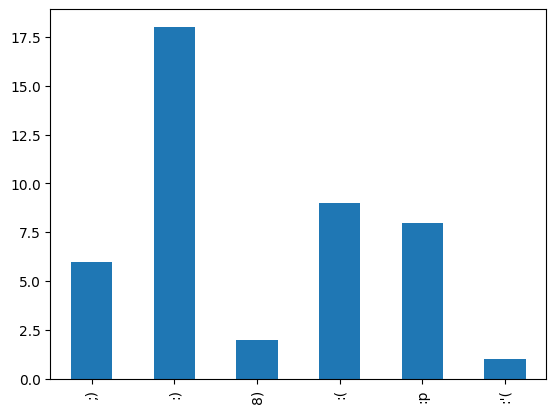

In [ ]:
# Emoticon counts
df["emoticons"].apply(lambda x: pd.Series(1, index=x)).fillna(0).sum().plot(kind='bar')

### Inicio de tokenización

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_bow = bow_vectorizer.fit_transform(df["clean_text"])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

print("Shape BoW:", X_bow.shape)
print("Shape TF-IDF:", X_tfidf.shape)


Shape BoW: (7613, 5000)
Shape TF-IDF: (7613, 5000)
